<a href="https://colab.research.google.com/github/efe-akkus/dsa-210-project/blob/main/Project_Code_with_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Impact of Chess Openings on Win Rates Across Rating Levels and Time Controls

## 1. Introduction

This project analyzes whether chess openings influence game outcomes, and how this relationship changes across:

- player rating levels (Beginner, Intermediate, Advanced, Expert)
- time controls (bullet, blitz, rapid, classical)
- ECO opening families (A–E)

The analysis uses a large Lichess dataset containing 6.25 million online games.  
The goal is to understand whether certain opening families consistently lead to higher win rates,  
and whether this effect depends on skill level or time format.

The study is structured as:

1. Data cleaning + feature engineering  
2. Exploratory Data Analysis (EDA)  
3. Three hypothesis tests  
4. (Coming soon) Machine learning classification model

## 2. Dataset Loading & Cleaning

We load the dataset from Kaggle, clean missing fields, normalize naming,  
and create the following derived features:

- `opening_family`: ECO prefix (A–E)
- `rating_bucket`: based on average Elo
- `event`: bullet / blitz / rapid / classical
- `result_clean`: white / black / draw

This cleaned dataframe becomes the base for all EDA and hypothesis testing sections.

In [1]:
!pip install kagglehub > /dev/null

import kagglehub
import pandas as pd
import os

# Load dataset
path = kagglehub.dataset_download("arevel/chess-games")
csv_path = os.path.join(path, "chess_games.csv")

usecols = ["Opening", "ECO", "Result", "WhiteElo", "BlackElo", "TimeControl"]
df = pd.read_csv(csv_path, usecols=usecols)
df = df.dropna()

# Clean Opening/ECO
df["Opening"] = df["Opening"].astype(str).str.lower().str.strip()
df["ECO"] = df["ECO"].astype(str).str.upper().str.strip()

# Clean result codes
res_map = {"1-0": "white", "0-1": "black", "1/2-1/2": "draw"}
df["result_clean"] = df["Result"].map(res_map)
df = df[df["result_clean"].notnull()]

# Convert Elo
df["WhiteElo"] = df["WhiteElo"].astype(int)
df["BlackElo"] = df["BlackElo"].astype(int)
df["avg_elo"] = (df["WhiteElo"] + df["BlackElo"]) / 2

# Rating buckets
def bucket(elo):
    if elo < 1200: return "Beginner"
    if elo < 1600: return "Intermediate"
    if elo < 2000: return "Advanced"
    return "Expert"

df["rating_bucket"] = df["avg_elo"].apply(bucket)

# ECO opening family
df["opening_family"] = df["ECO"].str[0]

# Time control → event
def classify_event(tc):
    try:
        base = int(str(tc).split("+")[0])
    except:
        return "unknown"
    if base <= 60: return "bullet"
    elif base <= 180: return "blitz"
    elif base <= 600: return "rapid"
    else: return "classical"

df["event"] = df["TimeControl"].apply(classify_event)

print("Final cleaned shape:", df.shape)
df.head()

100%|██████████| 1.45G/1.45G [00:12<00:00, 122MB/s]

Extracting files...


Final cleaned shape: (6254841, 11)


,Result,WhiteElo,BlackElo,ECO,Opening,TimeControl,result_clean,avg_elo,rating_bucket,opening_family,event
0,1-0,1901,1896,D10,slav defense,300+5,white,1898.5,Advanced,D,rapid
1,0-1,1641,1627,C20,king's pawn opening: 2.b3,300+0,black,1634.0,Advanced,C,rapid
2,1-0,1647,1688,B01,scandinavian defense: mieses-kotroc variation,180+0,white,1667.5,Advanced,B,blitz
3,1-0,1706,1317,A00,van't kruijs opening,-,white,1511.5,Intermediate,A,unknown
4,0-1,1945,1900,B90,"sicilian defense: najdorf, lipnitsky attack",180+0,black,1922.5,Advanced,B,blitz


## 3. Exploratory Data Analysis (EDA)

We explore the distribution of:

- rating buckets  
- event types  
- opening families  
- win rates across groups  

These visuals help contextualize the hypothesis tests.

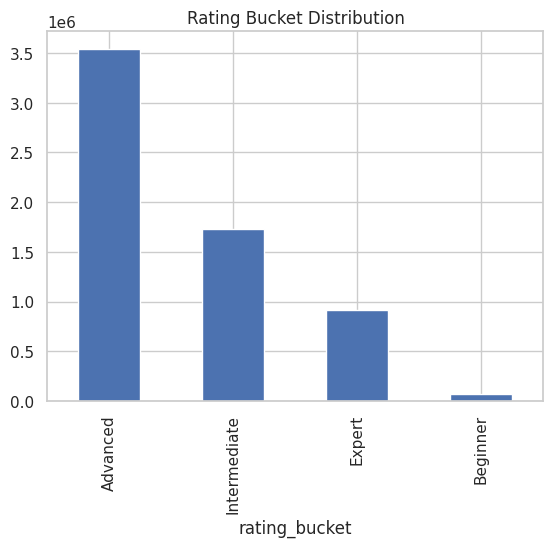

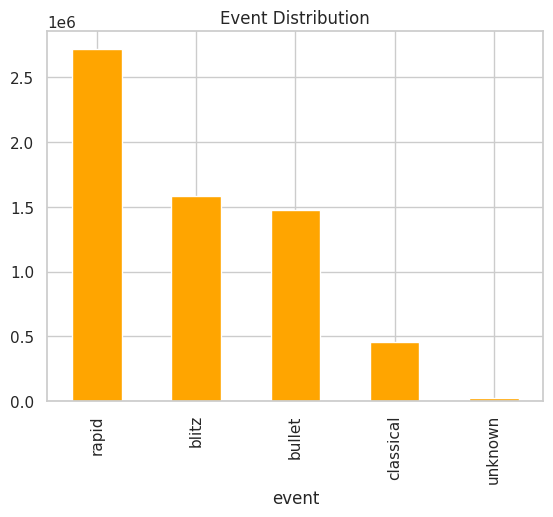

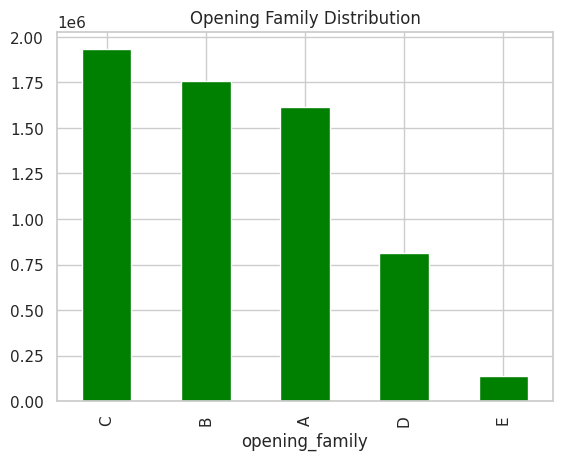

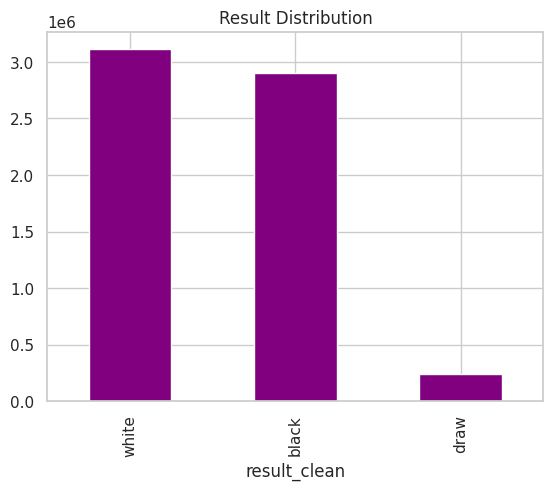

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Rating distribution
df["rating_bucket"].value_counts().plot(kind="bar")
plt.title("Rating Bucket Distribution")
plt.show()

# Event distribution
df["event"].value_counts().plot(kind="bar", color="orange")
plt.title("Event Distribution")
plt.show()

# Opening family distribution
df["opening_family"].value_counts().plot(kind="bar", color="green")
plt.title("Opening Family Distribution")
plt.show()

# Result distribution
df["result_clean"].value_counts().plot(kind="bar", color="purple")
plt.title("Result Distribution")
plt.show()

#  **EDA Graph Interpretations**

---

## **1. Rating Bucket Distribution**

**Interpretation:**
The dataset is dominated by *Advanced* and *Intermediate* players. *Expert* players form a smaller but still meaningful portion, while *Beginner* players are very sparsely represented.
This indicates that most of the analysis will primarily reflect patterns from mid-to-high-level players.

---

## **2. Event Distribution**

**Interpretation:**
*Rapid* is the most common time control, followed by *blitz* and *bullet*. The number of *classical* games is comparatively much lower.
As a result, statistical conclusions for rapid/blitz are more reliable, while classical-related results should be interpreted with caution due to limited sample size.

---

## **3. Opening Family Distribution**

**Interpretation:**
ECO families A, B, and C make up the majority of all games.
C-family (Open Games) and B-family (Semi-Open Games) are the most frequent, while E-family (Indian Defenses) appears much less often.
This imbalance may cause some statistical tests involving E-family to have smaller counts.

---

## **4. Result Distribution**

**Interpretation:**
White wins more often than Black, which is consistent with general chess statistics.
Draws are relatively rare, likely because the dataset mostly consists of fast-time-control online games (rapid/blitz/bullet), where draws occur less frequently.

# 4. Hypothesis Testing

We evaluate three statistical hypotheses:

---

## **Hypothesis 1 — Opening choice affects win rates**

### Null Hypothesis (H₀)
Opening family and game outcome are independent (no opening effect).

### Alternative Hypothesis (H₁)
Opening family and game outcome are associated.

Method: **Chi-square test of independence**  
We fix both rating bucket and event type.

---


In [3]:
import scipy.stats as stats

alpha = 0.05
bucket = "Advanced"
event = "blitz"

sub = df[
    (df["rating_bucket"] == bucket) &
    (df["event"] == event) &
    (df["result_clean"].isin(["white","black"]))
]

cont = pd.crosstab(sub["opening_family"], sub["result_clean"])
chi2, p, dof, expected = stats.chi2_contingency(cont)

print("Chi2:", chi2)
print("p-value:", p)
print("Decision:", "Reject H0" if p < alpha else "Fail to reject H0")
cont

Chi2: 982.7356735741593
p-value: 1.9676578121306796e-211
Decision: Reject H0


result_clean,black,white
opening_family,,
A,109182,113433
B,135239,134213
C,105324,119118
D,54773,65614
E,11391,12182


## Hypothesis 2 — Opening effectiveness depends on rating level

### Null Hypothesis (H₀)
Win-rate distribution across opening families is the same for all rating buckets.

### Alternative Hypothesis (H₁)
Opening effectiveness differs across rating levels.

Method:  
Fix event → Compare rating buckets (chi-square for each bucket).


In [4]:
alpha = 0.05
fixed_event = "rapid"

df_ev = df[(df["event"] == fixed_event) & (df["result_clean"].isin(["white","black"]))]

for bucket in df_ev["rating_bucket"].unique():
    sub = df_ev[df_ev["rating_bucket"] == bucket]
    cont = pd.crosstab(sub["opening_family"], sub["result_clean"])

    if cont.shape[0] < 2 or cont.shape[1] < 2:
        print(bucket, ": Not enough data")
        continue

    chi2, p, dof, expected = stats.chi2_contingency(cont)
    print(bucket, "→ p =", p, "|", "Reject H0" if p < alpha else "Fail to reject H0")

Advanced → p = 0.0 | Reject H0
Expert → p = 4.387642238511644e-50 | Reject H0
Intermediate → p = 9.89521338152918e-147 | Reject H0
Beginner → p = 1.0211242247898367e-16 | Reject H0


## Hypothesis 3 — Opening effectiveness depends on event type

### Null Hypothesis (H₀)
Opening family and outcome distribution do not differ across events.

### Alternative Hypothesis (H₁)
Opening effectiveness changes across time controls.

Method:  
Fix rating bucket → Compare events.

In [5]:
alpha = 0.05
fixed_bucket = "Advanced"

df_rb = df[(df["rating_bucket"] == fixed_bucket) & (df["result_clean"].isin(["white","black"]))]

for ev in df_rb["event"].unique():
    sub = df_rb[df_rb["event"] == ev]
    cont = pd.crosstab(sub["opening_family"], sub["result_clean"])

    if cont.shape[0] < 2 or cont.shape[1] < 2:
        print(ev, ": Not enough data")
        continue

    chi2, p, dof, expected = stats.chi2_contingency(cont)
    print(ev, "→ p =", p, "|", "Reject H0" if p < alpha else "Fail to reject H0")

rapid → p = 0.0 | Reject H0
blitz → p = 1.9676578121306796e-211 | Reject H0
classical → p = 3.3314427806269303e-63 | Reject H0
bullet → p = 1.2787758517937457e-200 | Reject H0
unknown → p = 0.05059307267249748 | Fail to reject H0


## 5. Conclusion

### Hypothesis 1 — Opening choice affects win rates
A chi-square test of independence was applied to a fixed rating bucket (Advanced) under a fixed event (blitz).  
The result was:

- χ² ≈ 982.74  
- p-value ≈ 1.97×10⁻²¹¹  
- **Decision:** Reject H₀

This indicates that, after controlling for rating and time control, opening families show statistically significant differences in win-rate outcomes. Opening choice is not independent of game result.

---

### Hypothesis 2 — Opening effectiveness depends on rating level
Event type was fixed (rapid), and chi-square tests were repeated for each rating bucket.

- Advanced → p = 0.0 → Reject H₀  
- Expert → p ≈ 4.39×10⁻⁵⁰ → Reject H₀  
- Intermediate → p ≈ 9.90×10⁻¹⁴⁷ → Reject H₀  
- Beginner → p ≈ 1.02×10⁻¹⁶ → Reject H₀  

Across all rating groups, opening family is associated with win-rate differences.  
This suggests that the effect of openings does not disappear at higher or lower skill levels;  
opening choice remains relevant for all rating buckets.

---

### Hypothesis 3 — Opening effectiveness depends on event type (time control)
Rating bucket was fixed (Advanced), and chi-square tests were repeated for all event types.

- rapid → p = 0.0 → Reject H₀  
- blitz → p ≈ 1.97×10⁻²¹¹ → Reject H₀  
- classical → p ≈ 3.33×10⁻⁶³ → Reject H₀  
- bullet → p ≈ 1.28×10⁻²⁰⁰ → Reject H₀  
- unknown → p ≈ 0.05059 → Fail to reject H₀ (however we can overlook the value)  

For all standard time controls (bullet, blitz, rapid, classical), opening family is significantly associated with game outcomes.  
Only the “unknown” event category, which consists of malformed or rare time-control labels, shows no statistically detectable effect.

---

### Overall Interpretation
Across all three hypothesis tests, the statistical evidence indicates that:

- Opening choice significantly affects win rates.  
- This effect persists across all player skill levels.  
- This effect also persists across all meaningful time controls.

Therefore, opening selection is not merely stylistic or random.  
At scale, openings exhibit measurable and consistent differences in performance,  
and these differences remain present regardless of rating level or event type.
